# 3.4 영화 리뷰 분류- 이진 분류 예제

리뷰 텍스트를 기반으로 영화 리뷰를 긍정(positive)과 부정(negative)으로 분류하는 방법을 배우겠습니다.

#### 코드 3-1 IMDB 데이터셋 로드하기

In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

num_words=10000 매개변수는 훈련 데이터에서 가장 자주 나타나는 단어 1만 개만 사용하겠다는 의미입니다.

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

1

In [5]:
max([max(sequence) for sequence in train_data])

9999

In [7]:
word_index = imdb.get_word_index()  # word_index는 단어와 정수 인덱스를 매핑한 딕셔너리 입니다.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  # 정수 인덱스와 단어를 매핑하도록 뒤집습니다.
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])  # 리뷰를 디코딩합니다. 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다.

### 3.4.2 데이터 준비
신경망에 숫자 리스트를 주입할 수는 없습니다. 리스트를 텐서로 바꾸는 두 가지 방법이 있습니다.
- 같은 길이가 되도록 리스트에 패딩을 추가하고 (samples, sequences_length) 크기의 정수 텐서로 변환합니다. 그다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용합니다.
- 리스트를 원-핫 인코딩(one-hot encoding)하여 0과 1의 벡터로 변환합니다. 그 다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망의 첫 번째 층으로 사용합니다.

#### 코드 3-2 정수 시퀀스를 이진 행렬로 인코딩하기

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [11]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [12]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

3.4.3 신경망 모델 만들기
Dense 층에 전달한 매개변수(16)는 은닉 유닛(hidden unit)의 개수입니다.<br/>
Dense 층을 쌓을 때 두 가지 중요한 구조상의 결정이 필요합니다.
- 얼마나 많은 층을 사용할 것인가?
- 각 층에 얼마나 많은 은닉 유닛을 둘 것인가?
4장에서 이런 결정을 하는데 도움이 되는 일반적인 원리를 배웁니다. 당분간은 필자를 믿고 선택한 다음 구조를 따라 주세요.
- 16개의 은닉 유닛을 가진 2개의 은닉 층
- 현재 리뷰를 감정을 스칼라 값의 예측으로 출력하는 세 번째 층<br/>

중간에 있는 은닉 층은 활성화 함수로 relu를 사용하고 마지막 층은 확률(0과 1 사이의 점수로, 어떤 샘플이 타깃 '1'일 가능성이 높다는 것은 그 리뷰가 긍정일 가능성이 높다는 것을 의미합니다)을 출력하기 위해 시그모이드 활성화 함수를 사용합니다.
![sigmoid relu](https://wiki.terzeron.com/artificial_intelligence/sigmoid_relu.png)

#### 코드 3-3 모델 정의하기

In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

D:\git\jongkwangyun.github.io\aikerasstudy\aiproject\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>활성화 함수가 무엇인가요? 왜 필요한가요?<br/>
>>relu와 같은 활성화 함수(또는 비선형성(non-linearity)이라고도 부릅니다)가 있다면 Dense 층은 선형적인 연산인 점곱과 덧셈 2개로 구성됩니다.<br/>
>output = dot(W, input) + b<br/>
>그러므로 이 층은 입력에 대한 선형 변환(아핀 변환)만을 학습할 수 있습니다.<br/>
>가설 공간을 풍부하게 만들어 층을 기게 만드는 장점을 살리기 위해서는 비선형성 또는 활성화 함수를 추가해야 합니다.<br/>

확률을 출력하는 모델을 사용할 때는 크로스엔트로피가 최선의 선택입니다.

#### 코드 3-4 모델 컴파일 하기

In [15]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### 코드 3-5 옵티마이저 설정하기

In [18]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### 코드 3-6 손실과 측정을 함수 객체로 지정하기

In [19]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

### 3.4.4 훈련 검증
#### 코드 3-7 검증 세트 준비하기

In [20]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

#### 코드 3-8 모델 훈련하기

In [21]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.6907 - loss: 0.5829 - val_acc: 0.8658 - val_loss: 0.3685
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8987 - loss: 0.3086 - val_acc: 0.8633 - val_loss: 0.3261
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9237 - loss: 0.2208 - val_acc: 0.8829 - val_loss: 0.2896
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9472 - loss: 0.1646 - val_acc: 0.8894 - val_loss: 0.2750
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9584 - loss: 0.1318 - val_acc: 0.8880 - val_loss: 0.2828
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9689 - loss: 0.1084 - val_acc: 0.8833 - val_loss: 0.2963
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9766 - loss: 0.0914 - val_acc: 0.8746 - val_loss: 0.3392
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9766 - loss: 0.0815 - val_acc: 0.8705 - val_loss: 0.3600
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9876 - loss:

model.fit() 메서드는 History 객체를 반환합니다. 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history 속성을 가지고 있습니다.

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

#### 코드 3-9 훈련과 검증 손실 그리기

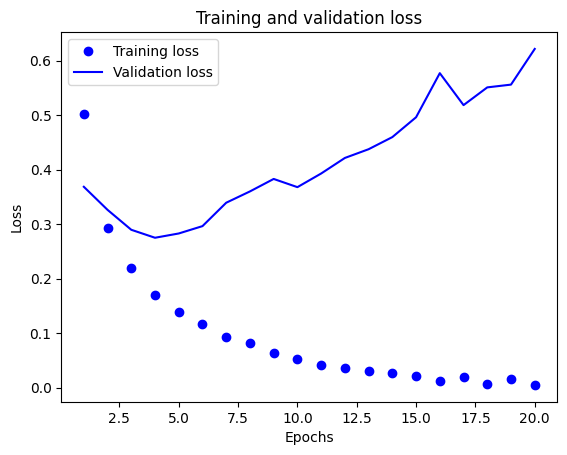

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 코드 3-10 훈련과 검증 정확도 그리기

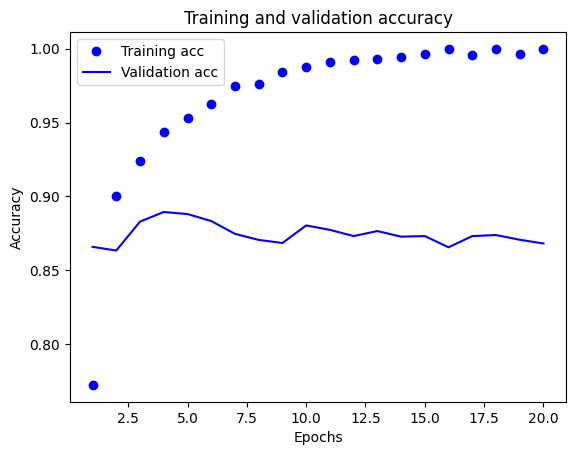

In [24]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

훈련 손실이 에포크마다 감소하고 훈련 정확도는 에포크마다 증가합니다. 검증 손실과 정확도는 네 번째 에포크에서 그래프가 역전되는 것 같습니다. 이것이 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에서는 잘 작동하지 않을 수 있다고 앞서 언급한 경고의 한 사례입니다. 정확한 용어로 말하면 과대적합(overfitting)되었다고 합니다.

#### 코드 3-11 모델을 처음부터 다시 훈련하기

In [25]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

D:\git\jongkwangyun.github.io\aikerasstudy\aiproject\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7261 - loss: 0.5768
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8974 - loss: 0.3101
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9231 - loss: 0.2275
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9333 - loss: 0.1921
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8855 - loss: 0.2841


[0.2829623520374298, 0.8867999911308289]

아주 단순한 방식으로도 87%의 정확도를 달성했습니다. 최고 수준의 기법을 사용하면 95%에 가까운 성능을 얻을 수 있습니다.

### 3.4.5 훈련된 모델로 새로운 데이터에 대해 예측하기
predict 메서드로 어떤 리뷰가 긍정일 확률을 예측할 수 있습니다.

In [26]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[0.15786928],
       [0.9977157 ],
       [0.64724433],
       ...,
       [0.08528664],
       [0.05559282],
       [0.47287664]], dtype=float32)

### 3.4.6 추가 실험
- 여기에는 2개의 은닉 층을 사용했습니다. 1개 또는 3개의 은닉층을 사용하고 검증과 테스트 정확도에 어떤 영향을 미치는지 확인해보세요.
- 층은 은닉 유닛을 추가하거나 줄여보세요. 32개의 유닛, 64개의 유닛 등
- binary_crossentropy 대신에 mse 손실 함수를 사용해 보세요.
- relu 대신에 tanh 활성화 함수(초창기 신경망에서 인기 있었던 함수입니다)를 사용해 보세요.

#### 1. 은닉층 변경

In [27]:
# 은닉층 2개 대신 1개 사용하기
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7416 - loss: 0.5522
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8967 - loss: 0.3114
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9147 - loss: 0.2449
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9271 - loss: 0.2097
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8880 - loss: 0.2795


[0.2795615494251251, 0.8886799812316895]

→ 정확도가 은닉층 2개 사용한 것과 유사하다

In [28]:
# 은닉층 2개 대신 3개 사용하기
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6410 - loss: 0.6013
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8968 - loss: 0.3120
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9253 - loss: 0.2151
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9396 - loss: 0.1739
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8716 - loss: 0.3232


[0.32478758692741394, 0.8736000061035156]

→ 정확도가 은닉층 2개 사용한 것과 유사하다

In [29]:
# 은닉층 10개 사용하기
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5144 - loss: 0.6925
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8071 - loss: 0.6128
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8939 - loss: 0.3036
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9249 - loss: 0.2136
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8604 - loss: 0.3454


[0.346760630607605, 0.860759973526001]

→ 정확도가 은닉층 2개 보다 10개가 약간 감소한다.

#### 2. 층의 은닉 유닛 변경

In [31]:
# 은닉 유닛 8개로 변경하기
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6362 - loss: 0.6237
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8876 - loss: 0.3889
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9183 - loss: 0.2615
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9297 - loss: 0.2093
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.8856 - loss: 0.2873


[0.28480055928230286, 0.887719988822937]

→ 정확도가 은닉층 8개 사용시 16개 사용한 것과 유사하다.

In [32]:
# 은닉 유닛 32개로 변경하기
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7158 - loss: 0.5584
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9018 - loss: 0.2721
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9220 - loss: 0.2107
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9361 - loss: 0.1776
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8829 - loss: 0.2935


[0.2903524935245514, 0.8854399919509888]

→ 정확도가 은닉층 32개 사용시 16개 사용한 것과 유사하다.

In [34]:
# 은닉 유닛 64개로 변경하기
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7347 - loss: 0.5456
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8996 - loss: 0.2741
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9261 - loss: 0.2073
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9347 - loss: 0.1747
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8816 - loss: 0.3000


[0.2963702082633972, 0.8843600153923035]

→ 정확도가 은닉 층 64개 사용시 16개 사용한 것과 유사하다.

#### 3. 손실 함수 변경

In [35]:
# 손실 함수 mse로 변경하기
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7024 - loss: 0.2081
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8922 - loss: 0.0983
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9172 - loss: 0.0712
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9303 - loss: 0.0594
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8843 - loss: 0.0844


[0.08380473405122757, 0.8865200281143188]

→ 정확도가 손실 함수 mse가 binary_crossentropy 사용한 것과 유사하다.

#### 4. 활성화 함수 변경

In [37]:
# 활성화 함수 tanh로 변경하기
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7506 - loss: 0.5247
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9051 - loss: 0.2573
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9283 - loss: 0.1884
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9443 - loss: 0.1520
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8798 - loss: 0.3111


[0.30809563398361206, 0.8807200193405151]

→ 정확도가 활성화 함수 tanh 가 relu 와 비슷하다.

### 3.4.7 정리
- 원본 데이터를 신경망에 텐서로 주입하기 위해서는 꽤 많은 전처리가 필요합니다. 단어 시퀀스는 이진 벡터로 인코딩 될 수 있고 다른 인코딩 방식도 있습니다.
- relu 활성화 함수와 함께 Dense 층을 쌓은 네트워크는 (감성 분류를 포함하여) 여러 종류의 문제에 적용할 수 있어 앞으로 자주 사용하게 될 것입니다.
- (출력 클래스가 2개인) 이진 분류 문제에서 네트워크는 하나의 유닛과 sigmoid 활성화 함수를 가진 Dense 층으로 끝나야 합니다. 이 신경망의 출력은 확률을 나타내는 0과 1 사이의 스칼라 값입니다.
- 이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 binary_crossentropy입니다.
- rmsprop 옵티마이저는 문제에 상관없이 일반적으로 충분히 좋은 선택입니다. 걱정할 거리가 하나 줄은 셈입니다.
- 훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 과대적합되기 시작하고 이전에 본적 없는 데이터에서는 결고가 점점 나빠지게 됩니다. 항상 훈련 세트 이외의 데이터에서 성능을 모니터링해야 합니다.